We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset.

In [13]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [15]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to (size,size) pixels. We shall use the NLL Loss later, this expects as target a class index ranging from 0 to C-1. So we don't need one-hot encoding for the target, but in principle we could do it as shown below. 

In [16]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])     # totensor has to be applied first and then resize coz the latter doesn't work on numpy arrays
#label_transform_one_hot = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y),value=1))

In [17]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = trans)
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = trans)
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [18]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


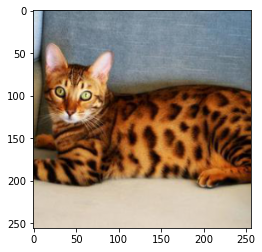

In [19]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [42]:
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN()
loss_function = nn.NLLLoss()


print(model)
        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128, 

## Training on a small batch

We shall now try to train the model above on a small batch. If we are able to overtrain (achieve almost total training accuracy) on this small dataset, we'll go ahead and check if we can achieve very high training accuracy on the entire training set.

In [27]:
# Trying to overtrain on a small batch from set r1

model1 = PetCNN()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate)


train_r1_loader_temp = DataLoader(train_r1,batch_size=256,shuffle=True)
x = next(iter(train_r1_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(200):
    model1.train()       # to set the model in training mode coz batchnorm will behave differently in the eval mode
    
    out = model1(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        model1.eval()
        with torch.no_grad():
            out = model1(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            #print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/256))
            
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))        # time taken for the last 20 iterations
    
            
        start = time.time()      
       
        

    


Iteration:20
Loss:3.611985683441162
Accuracy:0.03125
Time taken for the last 20 iterations: 57.301703691482544
Iteration:40
Loss:3.6104378700256348
Accuracy:0.0390625
Time taken for the last 20 iterations: 62.5105037689209
Iteration:60
Loss:3.4679336547851562
Accuracy:0.14453125
Time taken for the last 20 iterations: 62.36521553993225
Iteration:80
Loss:3.1575233936309814
Accuracy:0.421875
Time taken for the last 20 iterations: 61.93339657783508
Iteration:100
Loss:2.9201834201812744
Accuracy:0.57421875
Time taken for the last 20 iterations: 61.6844584941864
Iteration:120
Loss:2.7572784423828125
Accuracy:0.67578125
Time taken for the last 20 iterations: 63.0110878944397
Iteration:140
Loss:2.55171799659729
Accuracy:0.76953125
Time taken for the last 20 iterations: 62.28511714935303
Iteration:160
Loss:2.3424668312072754
Accuracy:0.828125
Time taken for the last 20 iterations: 61.8873929977417
Iteration:180
Loss:2.1209444999694824
Accuracy:0.87109375
Time taken for the last 20 iterations: 6

## Training on the entire dataset

We shall now check if we can overtrain our models on the entire datasets.

In [43]:
model1 = PetCNN()
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 31.375319719314575
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 34.29090714454651
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 36.60094356536865
Current training loss:3.606898069381714
Current training accuracy:0.037109375
Current validation loss:3.624429225921631
Current validation accuracy:0.03487592190504074
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 37.58177733421326
Current training loss:3.605029582977295
Current training accuracy:0.04736328125
Current validation loss:3.617532968521118
Current validation accuracy:0.036217302083969116
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 35.8166720867157
Current training loss:3.554330587387085
Current training accuracy:0.06396484375
Current validation loss:3.5496418476104736
Current validation accuracy:0.07109322398900986
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 36.466203451156616
Current training

Current training loss:2.792915105819702
Current training accuracy:0.2490234375
Current validation loss:2.9204187393188477
Current validation accuracy:0.2059020847082138
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 36.15915250778198
Current training loss:2.745598077774048
Current training accuracy:0.24267578125
Current validation loss:2.8819475173950195
Current validation accuracy:0.1951710283756256
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 39.06407380104065
Current training loss:2.8368139266967773
Current training accuracy:0.21826171875
Current validation loss:2.9799365997314453
Current validation accuracy:0.17572098970413208
Epoch:16
Iteration:1900
Time taken for the last 50 iterations: 39.816022872924805
Current training loss:2.701770305633545
Current training accuracy:0.248046875
Current validation loss:2.8642654418945312
Current validation accuracy:0.2005365490913391
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 38.24607610702

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 35.36908507347107
Current training loss:2.0855863094329834
Current training accuracy:0.4501953125
Current validation loss:2.5463833808898926
Current validation accuracy:0.2917504906654358
Epoch:30
Iteration:3450
Time taken for the last 50 iterations: 35.927753925323486
Current training loss:2.0432021617889404
Current training accuracy:0.46142578125
Current validation loss:2.51533579826355
Current validation accuracy:0.3071763813495636
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 36.16945457458496
Current training loss:2.1037018299102783
Current training accuracy:0.43798828125
Current validation loss:2.540353536605835
Current validation accuracy:0.2917504906654358
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 36.02987766265869
Current training loss:2.0143611431121826
Current training accuracy:0.45556640625
Current validation loss:2.5544071197509766
Current validation accuracy:0.281019449234

Current validation loss:2.3922693729400635
Current validation accuracy:0.33199194073677063
Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 35.5260443687439
Current training loss:1.554153561592102
Current training accuracy:0.6142578125
Current validation loss:2.3940629959106445
Current validation accuracy:0.34272301197052
Epoch:45
Iteration:5100
Time taken for the last 50 iterations: 36.18901562690735
Current training loss:1.5764167308807373
Current training accuracy:0.615234375
Current validation loss:2.4002556800842285
Current validation accuracy:0.33668678998947144
Epoch:45
Iteration:5150
Time taken for the last 50 iterations: 36.09338665008545
Current training loss:1.5534931421279907
Current training accuracy:0.615234375
Current validation loss:2.3839974403381348
Current validation accuracy:0.33601608872413635
Epoch:46
Iteration:5200
Time taken for the last 50 iterations: 35.63394236564636
Current training loss:1.595381259918213
Current training accuracy:0.58544921875

Current validation loss:2.2633752822875977
Current validation accuracy:0.3648557960987091
Epoch:59
Iteration:6700
Time taken for the last 50 iterations: 36.33649468421936
Current training loss:1.205484390258789
Current training accuracy:0.71484375
Current validation loss:2.327981948852539
Current validation accuracy:0.34071093797683716
Epoch:60
Iteration:6750
Time taken for the last 50 iterations: 35.39997434616089
Current training loss:1.1650453805923462
Current training accuracy:0.73828125
Current validation loss:2.321462631225586
Current validation accuracy:0.35680750012397766
Epoch:60
Iteration:6800
Time taken for the last 50 iterations: 36.09952998161316
Current training loss:1.1203161478042603
Current training accuracy:0.7607421875
Current validation loss:2.2705740928649902
Current validation accuracy:0.3601609766483307
Epoch:61
Iteration:6850
Time taken for the last 50 iterations: 35.405959606170654
Current training loss:1.1718109846115112
Current training accuracy:0.744140625
C

Current validation loss:2.3363418579101562
Current validation accuracy:0.36217305064201355
Epoch:74
Iteration:8350
Time taken for the last 50 iterations: 36.2607684135437
Current training loss:0.8828316330909729
Current training accuracy:0.841796875
Current validation loss:2.295142650604248
Current validation accuracy:0.36686787009239197
Epoch:74
Iteration:8400
Time taken for the last 50 iterations: 35.59336471557617
Current training loss:0.8702494502067566
Current training accuracy:0.837890625
Current validation loss:2.2951672077178955
Current validation accuracy:0.36753857135772705
Epoch:75
Iteration:8450
Time taken for the last 50 iterations: 36.37576913833618
Current training loss:0.8751708269119263
Current training accuracy:0.82080078125
Current validation loss:2.313683271408081
Current validation accuracy:0.3769282400608063
Epoch:75
Iteration:8500
Time taken for the last 50 iterations: 36.06414079666138
Current training loss:0.8445270657539368
Current training accuracy:0.85351562

Current training loss:0.7118316888809204
Current training accuracy:0.88720703125
Current validation loss:2.289842128753662
Current validation accuracy:0.3641851246356964
Epoch:89
Iteration:10000
Time taken for the last 50 iterations: 35.504733085632324
Current training loss:0.6789228320121765
Current training accuracy:0.8935546875
Current validation loss:2.292881965637207
Current validation accuracy:0.37961098551750183
Epoch:89
Iteration:10050
Time taken for the last 50 iterations: 36.285828828811646
Current training loss:0.6565598845481873
Current training accuracy:0.88818359375
Current validation loss:2.2844350337982178
Current validation accuracy:0.37961098551750183
Epoch:90
Iteration:10100
Time taken for the last 50 iterations: 35.518667459487915
Current training loss:0.7195059657096863
Current training accuracy:0.88818359375
Current validation loss:2.3310816287994385
Current validation accuracy:0.3755868673324585
Epoch:90
Iteration:10150
Time taken for the last 50 iterations: 35.9

Epoch:103
Iteration:11600
Time taken for the last 50 iterations: 36.297022104263306
Current training loss:0.5465970039367676
Current training accuracy:0.93359375
Current validation loss:2.2942287921905518
Current validation accuracy:0.38430583477020264
Epoch:104
Iteration:11650
Time taken for the last 50 iterations: 35.544315814971924
Current training loss:0.5517309904098511
Current training accuracy:0.92431640625
Current validation loss:2.2738678455352783
Current validation accuracy:0.37290409207344055
Epoch:104
Iteration:11700
Time taken for the last 50 iterations: 36.35203957557678
Current training loss:0.5906611084938049
Current training accuracy:0.9169921875
Current validation loss:2.313143253326416
Current validation accuracy:0.36351442337036133
Epoch:104
Iteration:11750
Time taken for the last 50 iterations: 36.26428437232971
Current training loss:0.5604889392852783
Current training accuracy:0.92529296875
Current validation loss:2.294989585876465
Current validation accuracy:0.36

Current validation loss:2.2905845642089844
Current validation accuracy:0.37357479333877563
Epoch:118
Iteration:13250
Time taken for the last 50 iterations: 35.635281801223755
Current training loss:0.49989378452301025
Current training accuracy:0.94287109375
Current validation loss:2.3108553886413574
Current validation accuracy:0.3749161660671234
Epoch:118
Iteration:13300
Time taken for the last 50 iterations: 36.379692792892456
Current training loss:0.49694177508354187
Current training accuracy:0.9453125
Current validation loss:2.2855286598205566
Current validation accuracy:0.37424546480178833
Epoch:119
Iteration:13350
Time taken for the last 50 iterations: 35.59451127052307
Current training loss:0.439504474401474
Current training accuracy:0.9560546875
Current validation loss:2.2855396270751953
Current validation accuracy:0.37961098551750183
Epoch:119
Iteration:13400
Time taken for the last 50 iterations: 36.24996304512024
Current training loss:0.44132548570632935
Current training accur

Epoch:132
Iteration:14850
Time taken for the last 50 iterations: 35.82287955284119
Current training loss:0.3975839614868164
Current training accuracy:0.95947265625
Current validation loss:2.321643352508545
Current validation accuracy:0.37424546480178833
Epoch:133
Iteration:14900
Time taken for the last 50 iterations: 35.335243225097656
Current training loss:0.3873863220214844
Current training accuracy:0.96533203125
Current validation loss:2.349210500717163
Current validation accuracy:0.3702213168144226
Epoch:133
Iteration:14950
Time taken for the last 50 iterations: 36.25670528411865
Current training loss:0.3841448724269867
Current training accuracy:0.96484375
Current validation loss:2.295818567276001
Current validation accuracy:0.380952388048172
Epoch:133
Iteration:15000
Time taken for the last 50 iterations: 36.125218868255615
Current training loss:0.33910688757896423
Current training accuracy:0.97265625
Current validation loss:2.294083595275879
Current validation accuracy:0.39168342

Current validation loss:2.288163661956787
Current validation accuracy:0.38363513350486755
Epoch:147
Iteration:16500
Time taken for the last 50 iterations: 35.62301015853882
Current training loss:0.3370714783668518
Current training accuracy:0.966796875
Current validation loss:2.3083086013793945
Current validation accuracy:0.3655264973640442
Epoch:147
Iteration:16550
Time taken for the last 50 iterations: 36.033512592315674
Current training loss:0.3333851993083954
Current training accuracy:0.97314453125
Current validation loss:2.3043322563171387
Current validation accuracy:0.3822937607765198
Epoch:148
Iteration:16600
Time taken for the last 50 iterations: 35.56843113899231
Current training loss:0.360535204410553
Current training accuracy:0.97021484375
Current validation loss:2.3430893421173096
Current validation accuracy:0.37290409207344055
Epoch:148
Iteration:16650
Time taken for the last 50 iterations: 36.31970191001892
Current training loss:0.3141939043998718
Current training accuracy

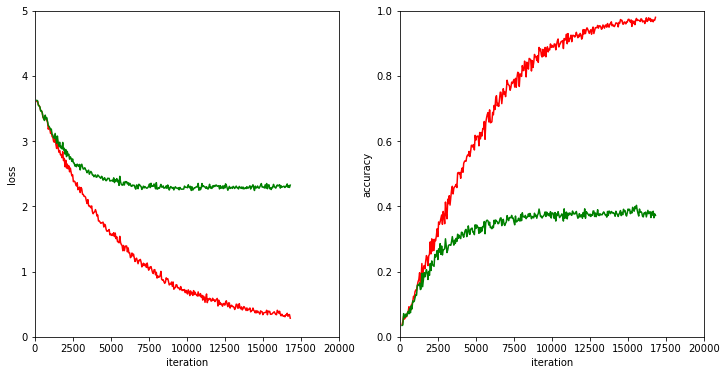

In [44]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,20000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,20000)
acc_graph.set_ylim(0,1)

plt.show()               


# Model (5 conv layers, more channels)

In [45]:
class PetCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=1),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(512, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

loss_function = nn.NLLLoss()


model1 = PetCNN()
print(model1)



PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128, 

In [46]:
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()

        

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 36.36138916015625
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 36.48229908943176
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 35.238192558288574
Current training loss:3.636014223098755
Current training accuracy:0.02880859375
Current validation loss:3.628664016723633
Current validation accuracy:0.026156941428780556
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 36.334829330444336
Current training loss:3.599989414215088
Current training accuracy:0.03857421875
Current validation loss:3.589080810546875
Current validation accuracy:0.04024145007133484
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 35.20381569862366
Current training loss:3.563922643661499
Current training accuracy:0.05810546875
Current validation loss:3.5638859272003174
Current validation accuracy:0.03822937607765198
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 35.90533638000488
Current train

Current training loss:2.917678117752075
Current training accuracy:0.21044921875
Current validation loss:2.981905698776245
Current validation accuracy:0.18980549275875092
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 35.32153129577637
Current training loss:2.900879144668579
Current training accuracy:0.17919921875
Current validation loss:3.0072760581970215
Current validation accuracy:0.16700200736522675
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 35.793864250183105
Current training loss:2.874135732650757
Current training accuracy:0.2060546875
Current validation loss:2.988163709640503
Current validation accuracy:0.17236754298210144
Epoch:16
Iteration:1900
Time taken for the last 50 iterations: 35.79877281188965
Current training loss:2.85561203956604
Current training accuracy:0.21484375
Current validation loss:2.95719313621521
Current validation accuracy:0.1804158240556717
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 35.420642137527466


Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 35.40489387512207
Current training loss:2.173797845840454
Current training accuracy:0.41064453125
Current validation loss:2.5667176246643066
Current validation accuracy:0.2850435972213745
Epoch:30
Iteration:3450
Time taken for the last 50 iterations: 36.136704206466675
Current training loss:2.1834936141967773
Current training accuracy:0.4130859375
Current validation loss:2.5714633464813232
Current validation accuracy:0.28772637248039246
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 35.507144927978516
Current training loss:2.228307008743286
Current training accuracy:0.38525390625
Current validation loss:2.6082847118377686
Current validation accuracy:0.28437289595603943
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 36.12647986412048
Current training loss:2.123469591140747
Current training accuracy:0.42236328125
Current validation loss:2.5309054851531982
Current validation accuracy:0.295774638

Current validation loss:2.4300777912139893
Current validation accuracy:0.32662642002105713
Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 35.35146522521973
Current training loss:1.692307472229004
Current training accuracy:0.56591796875
Current validation loss:2.439086675643921
Current validation accuracy:0.32595574855804443
Epoch:45
Iteration:5100
Time taken for the last 50 iterations: 36.319256067276
Current training loss:1.6908233165740967
Current training accuracy:0.5693359375
Current validation loss:2.4867138862609863
Current validation accuracy:0.3239436745643616
Epoch:45
Iteration:5150
Time taken for the last 50 iterations: 35.95973491668701
Current training loss:1.6721892356872559
Current training accuracy:0.55810546875
Current validation loss:2.445516586303711
Current validation accuracy:0.32059019804000854
Epoch:46
Iteration:5200
Time taken for the last 50 iterations: 35.57659029960632
Current training loss:1.6149264574050903
Current training accuracy:0.6083984

Current training loss:1.2619060277938843
Current training accuracy:0.71826171875
Current validation loss:2.3334178924560547
Current validation accuracy:0.3501006066799164
Epoch:59
Iteration:6700
Time taken for the last 50 iterations: 37.23560047149658
Current training loss:1.28476083278656
Current training accuracy:0.72412109375
Current validation loss:2.3290977478027344
Current validation accuracy:0.3547954261302948
Epoch:60
Iteration:6750
Time taken for the last 50 iterations: 37.0760543346405
Current training loss:1.2516926527023315
Current training accuracy:0.7294921875
Current validation loss:2.3249778747558594
Current validation accuracy:0.35077130794525146
Epoch:60
Iteration:6800
Time taken for the last 50 iterations: 36.879003047943115
Current training loss:1.268855333328247
Current training accuracy:0.6982421875
Current validation loss:2.3607654571533203
Current validation accuracy:0.3454057574272156
Epoch:61
Iteration:6850
Time taken for the last 50 iterations: 35.79531288146

Epoch:74
Iteration:8300
Time taken for the last 50 iterations: 35.28908038139343
Current training loss:1.0468213558197021
Current training accuracy:0.77001953125
Current validation loss:2.356551170349121
Current validation accuracy:0.3547954261302948
Epoch:74
Iteration:8350
Time taken for the last 50 iterations: 36.055527210235596
Current training loss:0.9834683537483215
Current training accuracy:0.81494140625
Current validation loss:2.2887778282165527
Current validation accuracy:0.3661971688270569
Epoch:74
Iteration:8400
Time taken for the last 50 iterations: 37.07045555114746
Current training loss:1.01129949092865
Current training accuracy:0.7978515625
Current validation loss:2.3284401893615723
Current validation accuracy:0.3541247546672821
Epoch:75
Iteration:8450
Time taken for the last 50 iterations: 36.08639144897461
Current training loss:0.9002834558486938
Current training accuracy:0.828125
Current validation loss:2.261012077331543
Current validation accuracy:0.380952388048172
Ep

Epoch:88
Iteration:9950
Time taken for the last 50 iterations: 36.22864079475403
Current training loss:0.7460678815841675
Current training accuracy:0.87890625
Current validation loss:2.2823257446289062
Current validation accuracy:0.37223339080810547
Epoch:89
Iteration:10000
Time taken for the last 50 iterations: 35.2940878868103
Current training loss:0.8448351621627808
Current training accuracy:0.85107421875
Current validation loss:2.3233978748321533
Current validation accuracy:0.36150234937667847
Epoch:89
Iteration:10050
Time taken for the last 50 iterations: 37.93120098114014


KeyboardInterrupt: 

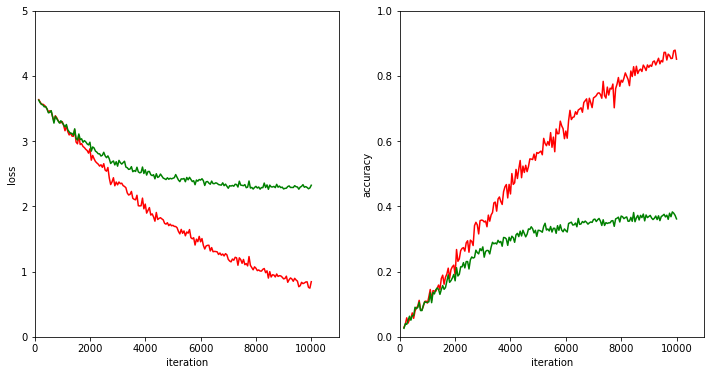

In [47]:
            
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,11000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,11000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model (4 conv layers)

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, pad

Current validation loss:3.331782341003418
Current validation accuracy:0.09926223754882812
Epoch:12
Iteration:1400
Time taken for the last 50 iterations: 11.344427347183228
Current training loss:3.1744396686553955
Current training accuracy:0.1318359375
Current validation loss:3.2184247970581055
Current validation accuracy:0.11267605423927307
Epoch:12
Iteration:1450
Time taken for the last 50 iterations: 11.610923290252686
Current training loss:3.1860222816467285
Current training accuracy:0.1240234375
Current validation loss:3.1943211555480957
Current validation accuracy:0.12474849075078964
Epoch:13
Iteration:1500
Time taken for the last 50 iterations: 13.08808422088623
Current training loss:3.250257968902588
Current training accuracy:0.11083984375
Current validation loss:3.309535026550293
Current validation accuracy:0.09657947719097137
Epoch:13
Iteration:1550
Time taken for the last 50 iterations: 11.918785333633423
Current training loss:3.1141154766082764
Current training accuracy:0.14

Current training loss:2.784008264541626
Current training accuracy:0.23095703125
Current validation loss:2.9513320922851562
Current validation accuracy:0.18980549275875092
Epoch:27
Iteration:3050
Time taken for the last 50 iterations: 11.34835147857666
Current training loss:2.885071039199829
Current training accuracy:0.1943359375
Current validation loss:3.0431885719299316
Current validation accuracy:0.17035546898841858
Epoch:27
Iteration:3100
Time taken for the last 50 iterations: 11.836698770523071
Current training loss:2.679905891418457
Current training accuracy:0.25537109375
Current validation loss:2.8779823780059814
Current validation accuracy:0.20858484506607056
Epoch:28
Iteration:3150
Time taken for the last 50 iterations: 11.309858560562134
Current training loss:2.8917343616485596
Current training accuracy:0.1962890625
Current validation loss:3.06708025932312
Current validation accuracy:0.17169684171676636
Epoch:28
Iteration:3200
Time taken for the last 50 iterations: 11.42659211

Epoch:41
Iteration:4650
Time taken for the last 50 iterations: 12.509127616882324
Current training loss:2.515768527984619
Current training accuracy:0.2861328125
Current validation loss:2.871302366256714
Current validation accuracy:0.22468142211437225
Epoch:41
Iteration:4700
Time taken for the last 50 iterations: 12.349563121795654
Current training loss:2.4886138439178467
Current training accuracy:0.31103515625
Current validation loss:2.840596914291382
Current validation accuracy:0.22132796049118042
Epoch:42
Iteration:4750
Time taken for the last 50 iterations: 12.131741762161255
Current training loss:2.5920581817626953
Current training accuracy:0.2724609375
Current validation loss:2.9098801612854004
Current validation accuracy:0.2065727710723877
Epoch:42
Iteration:4800
Time taken for the last 50 iterations: 12.874398946762085
Current training loss:2.4893417358398438
Current training accuracy:0.291015625
Current validation loss:2.8923885822296143
Current validation accuracy:0.2112676054

Current validation loss:2.9238905906677246
Current validation accuracy:0.2173038274049759
Epoch:56
Iteration:6300
Time taken for the last 50 iterations: 10.949422836303711
Current training loss:2.312368392944336
Current training accuracy:0.33740234375
Current validation loss:2.8243582248687744
Current validation accuracy:0.23407109081745148
Epoch:56
Iteration:6350
Time taken for the last 50 iterations: 11.188064575195312
Current training loss:2.347586154937744
Current training accuracy:0.34375
Current validation loss:2.835056781768799
Current validation accuracy:0.23205901682376862
Epoch:57
Iteration:6400
Time taken for the last 50 iterations: 11.722463607788086
Current training loss:2.4328722953796387
Current training accuracy:0.31201171875
Current validation loss:2.8558120727539062
Current validation accuracy:0.22937625646591187
Epoch:57
Iteration:6450
Time taken for the last 50 iterations: 13.052119731903076
Current training loss:2.442340135574341
Current training accuracy:0.296875


Current training loss:2.2146668434143066
Current training accuracy:0.3798828125
Current validation loss:2.8946845531463623
Current validation accuracy:0.2427900731563568
Epoch:70
Iteration:7950
Time taken for the last 50 iterations: 13.060404777526855
Current training loss:2.2488183975219727
Current training accuracy:0.341796875
Current validation loss:2.911726236343384
Current validation accuracy:0.24077799916267395
Epoch:71
Iteration:8000
Time taken for the last 50 iterations: 12.746522426605225
Current training loss:2.2706987857818604
Current training accuracy:0.3583984375
Current validation loss:2.9358692169189453
Current validation accuracy:0.22937625646591187
Epoch:71
Iteration:8050
Time taken for the last 50 iterations: 12.247645378112793
Current training loss:2.1081717014312744
Current training accuracy:0.38623046875
Current validation loss:2.843076705932617
Current validation accuracy:0.24547283351421356
Epoch:72
Iteration:8100
Time taken for the last 50 iterations: 11.9701690

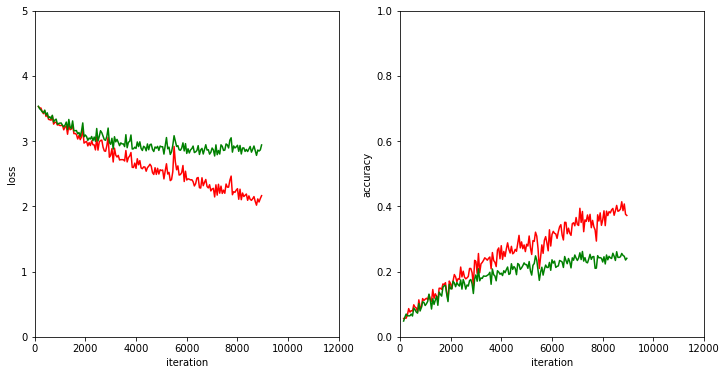

In [23]:
class PetCNNreg(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.Dropout2d(0.2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=4, stride=2),
                                    nn.Dropout2d(0.3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2),
                                    nn.MaxPool2d(kernel_size=2, stride=1),   #default stride is kernel size
                                    nn.Dropout2d(0.4),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.Dropout(0.4),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(256, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


loss_function = nn.NLLLoss()

model1 = PetCNNreg()
print(model)


learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 80

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                
               
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,12000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,12000)
acc_graph.set_ylim(0,1)

plt.show()
            
        

    

        

The validation set performance is not improving any more, but the network can obviously be trained further as the training set performance hasn't plateaued. So we'll train it for more iterations.

Epoch:0
Iteration:17950
Time taken for the last 50 iterations: 5.7900710105896
Epoch:0
Iteration:18000
Time taken for the last 50 iterations: 9.388247728347778
Epoch:1
Iteration:18050
Time taken for the last 50 iterations: 9.321258306503296
Current training loss:1.2163574695587158
Current training accuracy:0.65185546875
Current validation loss:2.913093090057373
Current validation accuracy:0.2736418545246124
Epoch:1
Iteration:18100
Time taken for the last 50 iterations: 9.551480054855347
Current training loss:1.3336275815963745
Current training accuracy:0.6201171875
Current validation loss:2.8695175647735596
Current validation accuracy:0.276324599981308
Epoch:2
Iteration:18150
Time taken for the last 50 iterations: 9.230607986450195
Current training loss:1.4830610752105713
Current training accuracy:0.57470703125
Current validation loss:2.9584200382232666
Current validation accuracy:0.26224011182785034
Epoch:2
Iteration:18200
Time taken for the last 50 iterations: 9.568613290786743
Curre

Epoch:15
Iteration:19650
Time taken for the last 50 iterations: 11.069786310195923
Current training loss:1.2422230243682861
Current training accuracy:0.64453125
Current validation loss:2.958077907562256
Current validation accuracy:0.2682763338088989
Epoch:15
Iteration:19700
Time taken for the last 50 iterations: 11.185637474060059
Current training loss:1.1650149822235107
Current training accuracy:0.66015625
Current validation loss:2.859780788421631
Current validation accuracy:0.28303152322769165
Epoch:16
Iteration:19750
Time taken for the last 50 iterations: 10.871485233306885
Current training loss:1.287509799003601
Current training accuracy:0.64990234375
Current validation loss:2.8313043117523193
Current validation accuracy:0.2635814845561981
Epoch:16
Iteration:19800
Time taken for the last 50 iterations: 11.109349489212036
Current training loss:1.30172860622406
Current training accuracy:0.6396484375
Current validation loss:2.8154075145721436
Current validation accuracy:0.278336673974

Current validation loss:2.9035141468048096
Current validation accuracy:0.265593558549881
Epoch:30
Iteration:21300
Time taken for the last 50 iterations: 11.523619174957275
Current training loss:1.1449360847473145
Current training accuracy:0.66796875
Current validation loss:2.946681499481201
Current validation accuracy:0.26089873909950256
Epoch:30
Iteration:21350
Time taken for the last 50 iterations: 11.438602685928345
Current training loss:1.1746984720230103
Current training accuracy:0.66259765625
Current validation loss:2.9270284175872803
Current validation accuracy:0.26693493127822876
Epoch:31
Iteration:21400
Time taken for the last 50 iterations: 12.19918155670166
Current training loss:1.2585813999176025
Current training accuracy:0.6416015625
Current validation loss:2.92315411567688
Current validation accuracy:0.2582159638404846
Epoch:31
Iteration:21450
Time taken for the last 50 iterations: 12.078919887542725
Current training loss:1.1899369955062866
Current training accuracy:0.656

Current training loss:1.113513708114624
Current training accuracy:0.68701171875
Current validation loss:2.9725608825683594
Current validation accuracy:0.26760563254356384
Epoch:44
Iteration:22950
Time taken for the last 50 iterations: 11.10806393623352
Current training loss:0.9848469495773315
Current training accuracy:0.72119140625
Current validation loss:2.9343504905700684
Current validation accuracy:0.28303152322769165
Epoch:45
Iteration:23000
Time taken for the last 50 iterations: 10.93188738822937
Current training loss:1.1406348943710327
Current training accuracy:0.66943359375
Current validation loss:3.029695987701416
Current validation accuracy:0.2756539285182953
Epoch:45
Iteration:23050
Time taken for the last 50 iterations: 11.255839586257935
Current training loss:1.0517586469650269
Current training accuracy:0.69775390625
Current validation loss:2.863800048828125
Current validation accuracy:0.27766600251197815
Epoch:46
Iteration:23100
Time taken for the last 50 iterations: 11.02

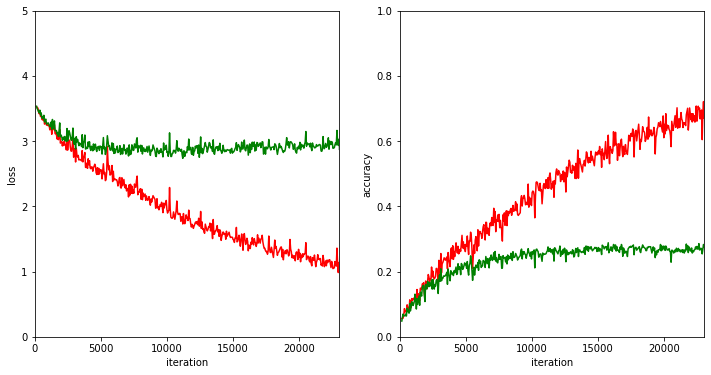

In [26]:
num_epochs = 50

start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r1_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_r1_part = DataLoader(train_r1,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r1_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                
               
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,23000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,23000)
acc_graph.set_ylim(0,1)

plt.show()
            